Connected to base (Python 3.12.3)

# 0 Introdução
 Este notebook contem todo o processo para a realização da Modelagem do modelo final usado para predizer as notas do enem 2023 baseados em dados socioeconomicos.
# Objetivo:
 Construir e avaliar modelos preditivos para estimar a nota do ENEM com base nas características dos candidatos.
# Estratégia de Modelagem
 Neste notebook iremos testar diferentes abordagens de modelagem:
## Modelos a serem testados:
 - **Modelos básicos**: Para estabelecer uma baseline de algoritmos simples.
 - **Modelos baseados em árvores**: Capazes de capturar complexidades e interações não-lineares nos dados.
## Pré-processamento dos Dados:
 - **Encoders e transformações**: Aplicação de StandardScaler, OneHotEncoder, OrdinalEncoder conforme a natureza de cada variável.
 - **Tratamento de dados**: Resolução de problemas específicos encontrados nos dados, como categorias inconsistentes em variáveis ordinais.
## Otimização e Avaliação:
 - **Tunagem de hiperparâmetros** através de **otimização bayesiana** para o modelo com melhor desempenho, visando maximizar a capacidade preditiva.
 - **Comparação com baseline de referência**: Utilizando a média das notas do ENEM como métrica de comparação.
## Interpretabilidade:
 - **Análise SHAP**: Para compreender a contribuição de cada feature nas predições do modelo e aumentar a interpretabilidade dos resultados.
## Deploy:
 - **Aplicação Streamlit**: Será realizado um deploy do modelo final através do Streamlit para disponibilizar a predição de forma interativa.

In [ ]:
import optuna as opt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
# Importação dos algoritmos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

 Importação dos dados que foram preparados no notebook 'tratamento_EDA.py'. Os dados foram armazenados no formato pickle, sendo salvos e carregados com a biblioteca joblib.

 Carregando os dados preparados:

In [ ]:
X_train = joblib.load('data/X_train.pkl')
X_test = joblib.load('data/X_test.pkl')
y_train = joblib.load('data/y_train.pkl')
y_test = joblib.load('data/y_test.pkl')

In [ ]:
X_test.shape

(535653, 34)

In [ ]:
y_test.shape

(535653,)

 Para evitar qualquer tipo de viés no modelo, decidiu-se pela remoção de features sensíveis (sexo e raça).

In [ ]:
features_sensíveis = ['TP_SEXO', 'TP_COR_RACA']
X_train = X_train.drop(columns=features_sensíveis, errors='ignore')
X_test = X_test.drop(columns=features_sensíveis, errors='ignore')

print(f"Features removidas: {features_sensíveis}")
print(f"Shape dos dados após remoção: {X_train.shape}")

X_train.columns

Features removidas: ['TP_SEXO', 'TP_COR_RACA']
Shape dos dados após remoção: (2142611, 32)


Index(['TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL', 'TP_ST_CONCLUSAO', 'TP_ESCOLA',
       'IN_TREINEIRO', 'SG_UF_PROVA', 'TP_LINGUA', 'Q001', 'Q002', 'Q003',
       'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

# 1. Criação das funções de avaliação:

 Faz uma avaliação direta entre o valor predito e o valor real. Esta função será usada apenas para testar o modelo.

In [ ]:
def avaliar_modelo(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return {
        "MAE": mae,
        "MAPE (%)": mape,
        "MSE": mse,
        "RMSE": rmse
    }

# 1.1 Validação Cruzada
 Realiza uma validação cruzada. Esta função será usada para testar diferentes abordagens de feature engineering, aplicando diferentes possibilidades de avaliação do modelo.

In [ ]:
def avaliar_modelo_cv(pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error'):
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
    return scores

In [ ]:
print(X_train.shape)
X_train.columns

(2142611, 32)


Index(['TP_FAIXA_ETARIA', 'TP_ESTADO_CIVIL', 'TP_ST_CONCLUSAO', 'TP_ESCOLA',
       'IN_TREINEIRO', 'SG_UF_PROVA', 'TP_LINGUA', 'Q001', 'Q002', 'Q003',
       'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012',
       'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
       'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [ ]:
#Cardinalidade
X_train.nunique().sort_values(ascending=False)

SG_UF_PROVA        27
TP_FAIXA_ETARIA    20
Q005               20
Q006               17
Q001                8
Q002                8
Q003                6
Q004                6
Q017                5
Q019                5
Q012                5
Q022                5
Q024                5
Q016                5
Q015                5
Q014                5
Q013                5
Q010                5
Q011                5
TP_ESTADO_CIVIL     5
Q009                5
Q008                5
Q007                4
TP_ST_CONCLUSAO     4
TP_ESCOLA           3
TP_LINGUA           2
Q018                2
IN_TREINEIRO        2
Q020                2
Q021                2
Q023                2
Q025                2
dtype: int64

In [ ]:
resultados_modelos = {}

# 2. Criação de funções de feature engineering:

 A classe TratadorNaoSei trata um problema específico do questionário socioeconômico do ENEM: candidatos que não sabem informações os pais.

 O Problema:

 Nas questões Q001-Q004, alguns candidatos respondem "Não sei" (códigos 'H' e 'F'). Simplesmente ignorar essas respostas desperdiçaria informação valiosa.

 A Solução:
 - Cria novas variáveis (Q001_naosei, Q002_naosei, etc.) que marcam quando o candidato não soube responder.
 - Converte "Não sei" para nulo, cria uma nova coluna especifica para cada pergunta e permite imputação posterior do valor nulo na coluna original.
 - Em vez de perder a informação "não sei", o modelo agora pode aprender que o próprio desconhecimento é um preditor relevante da nota final.

In [ ]:
class TratadorNaoSei(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['Q001_naosei'] = np.where(X_['Q001'] == 'H', 1, 0)
        X_['Q002_naosei'] = np.where(X_['Q002'] == 'H', 1, 0)
        X_['Q003_naosei'] = np.where(X_['Q003'] == 'F', 1, 0)
        X_['Q004_naosei'] = np.where(X_['Q004'] == 'F', 1, 0)
        X_.loc[X_['Q001'] == 'H', 'Q001'] = np.nan
        X_.loc[X_['Q002'] == 'H', 'Q002'] = np.nan
        X_.loc[X_['Q003'] == 'F', 'Q003'] = np.nan
        X_.loc[X_['Q004'] == 'F', 'Q004'] = np.nan
        return X_

# 2. Criação de funções de feature engineering:

 A classe TratadorNaoSei trata um problema específico do questionário socioeconômico do ENEM: candidatos que não sabem informações os pais.

 O Problema:

 Nas questões Q001-Q004, alguns candidatos respondem "Não sei" (códigos 'H' e 'F'). Simplesmente ignorar essas respostas desperdiçaria informação valiosa.

 A Solução:
 - Cria novas variáveis (Q001_naosei, Q002_naosei, etc.) que marcam quando o candidato não soube responder.
 - Converte "Não sei" para nulo, cria uma nova coluna especifica para cada pergunta e permite imputação posterior do valor nulo na coluna original.
 - Em vez de perder a informação "não sei", o modelo agora pode aprender que o próprio desconhecimento é um preditor relevante da nota final.

In [ ]:
class TratadorNaoSei(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_ = X.copy()
        X_['Q001_naosei'] = np.where(X_['Q001'] == 'H', 1, 0)
        X_['Q002_naosei'] = np.where(X_['Q002'] == 'H', 1, 0)
        X_['Q003_naosei'] = np.where(X_['Q003'] == 'F', 1, 0)
        X_['Q004_naosei'] = np.where(X_['Q004'] == 'F', 1, 0)
        X_.loc[X_['Q001'] == 'H', 'Q001'] = np.nan
        X_.loc[X_['Q002'] == 'H', 'Q002'] = np.nan
        X_.loc[X_['Q003'] == 'F', 'Q003'] = np.nan
        X_.loc[X_['Q004'] == 'F', 'Q004'] = np.nan
        return X_

 Classe 'AgrupadorCategorias' é usada para agrupar categorias que possuem classes com poucas observações.

In [ ]:
class AgrupadorCategorias(BaseEstimator, TransformerMixin):
    """
    Aplica mapeamentos categóricos para reduzir cardinalidade
    """
    def __init__(self):
        # Idade: 1=Adolescente, 2=Jovem, 3=Adulto jovem, 4=Meia-idade, 5=Idoso
        self.mapa_grupos_idade = {
            1: 1, 2: 1,                                    # Adolescente
            3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2,     # Jovem adulto
            10: 3, 11: 3, 12: 3, 13: 3,                    # Adulto jovem
            14: 4, 15: 4, 16: 4, 17: 4,                    # Meia-idade
            18: 5, 19: 5, 20: 5                            # Idoso
        }
        
        # Renda: 0=Sem renda, 1=Classe E, 2=Classe D, 3=Classe C, 4=Classe B, 5=Classe A
        self.renda_abep = {
            "A": 0, "B": 1, "C": 2, "D": 2, "E": 3, "F": 3, 
            "G": 3, "H": 3, "I": 4, "J": 4, "K": 4, "L": 4, 
            "M": 4, "N": 5, "O": 5, "P": 5, "Q": 5
        }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        
        if 'TP_FAIXA_ETARIA' in X_.columns:
            X_['TP_FAIXA_ETARIA'] = X_['TP_FAIXA_ETARIA'].map(self.mapa_grupos_idade)
        
        if 'Q006' in X_.columns:
            X_['Q006'] = X_['Q006'].map(self.renda_abep)
            

        return X_

# 3. Criação da pipeline para modelos que precisam de escalonamento:

 Foram realizados diferentes testes de performance com essa pipeline, incluindo a aplicação de diferentes escalonadores, diferentes encoders e aplicação de encoders distintos em diferentes categorias.

 Todos esses testes foram realizados usando apenas a validação do modelo através da validação cruzada.

 A pipeline que se destacou está apresentada abaixo. Porém, sabemos que modelos mais simples podem não ter a capacidade de entender padrões de dados mais complexos.

 Vale ressaltar que o modelo final de cada algoritmo só foi rodado nos dados de validação e teste após a criação da pipeline final!

In [ ]:
def criar_pipeline(modelo):
    col_numericas = ['Q005']

    categorica_nominal = [
        'TP_ESTADO_CIVIL',
        'TP_ESCOLA', 
        'SG_UF_PROVA',  
    ]

    categorica_ordinal = [
        'TP_ST_CONCLUSAO', 'TP_FAIXA_ETARIA', 'Q006',  # Idade e renda como ordinal numérica
        'Q001', 'Q002', 'Q003', 'Q004', 'Q007', 'Q008', 'Q009',
        'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
        'Q017', 'Q019', 'Q022', 'Q024', 'Q018', 'Q020', 'Q021', 'Q023',
        'Q025', 'IN_TREINEIRO', 'TP_LINGUA'
    ]
    
    transformador_numerico = Pipeline(steps=[
        ("scaler", StandardScaler())
    ])

    transformador_onehot = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown='ignore'))
    ])

    transformador_categorico_ordinal = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='Desconhecido')),
        ("ordinal", OrdinalEncoder())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", transformador_numerico, col_numericas),
            ("cat_onehot", transformador_onehot, categorica_nominal),
            ("cat_ordinal", transformador_categorico_ordinal, categorica_ordinal)
        ],
        remainder='passthrough'
    )

    pipeline_final = Pipeline(steps=[
        ("tratador_nao_sei", TratadorNaoSei()),
        ('agrupamento', AgrupadorCategorias()),
        ("preprocess", preprocessor),
        ("modelo", modelo)
    ])

    return pipeline_final

 Lista de modelos utilizados, todos usando o random_state para reprodutibilidade:

In [ ]:
modelos_com_escala = {
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
}

 Avaliação dos modelos:

In [ ]:
for nome_modelo, modelo in modelos_com_escala.items():
    pipeline = criar_pipeline(modelo)
    scores = avaliar_modelo_cv(pipeline, X_train, y_train)
    print(f"{nome_modelo}: RMSE médio = {-scores.mean():.4f}")
    # Teste final com X_test
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)
    metricas_test = avaliar_modelo(y_test, y_pred_test)
    resultados_modelos[nome_modelo] = [-scores.mean(), metricas_test['RMSE']]

Ridge: RMSE médio = 78.0516
Lasso: RMSE médio = 78.1293
ElasticNet: RMSE médio = 78.4678


 Os modelos lineares apresentam limitações ao lidar com dados complexos e não-lineares,
 especialmente quando há interações entre variáveis que não são capturadas por transformações simples.
 Para superar essas limitações, testamos agora modelos baseados em árvores que:
 1. Capturam automaticamente interações não-lineares entre features
 2. Não necessitam de escalonamento dos dados
 3. Podem lidar melhor com diferentes tipos de variáveis categóricas
 Por isso, criamos uma nova pipeline otimizada para esses algoritmos.

# 4. Criação da pipeline para modelos baseados em árvore:

 Os modelos baseados em árvore possuem características distintas dos modelos lineares, permitindo uma abordagem de pré-processamento mais simplificada:

 **Vantagens dos modelos em árvore:**
 - Não necessitam de escalonamento dos dados numéricos
 - Capturam automaticamente interações não-lineares entre features
 - São mais robustos a outliers
 - Lidam melhor com dados categóricos codificados (através de splits nos valores encoded)

 **Simplificações na pipeline:**
 - Remoção do StandardScaler (desnecessário para árvores)
 - Remoção do AgrupadorCategorias (árvores lidam melhor com alta cardinalidade)
 - Manutenção dos mesmos encoders categóricos (OrdinalEncoder e OneHotEncoder)

 Vale ressaltar que o modelo final de cada algoritmo, assim como na pipeline anterior, só vai ser rodado nos dados de validação e teste após a criação da pipeline final!

In [ ]:
def criar_pipeline_arvore(modelo):
    col_numericas = ['Q005']
    categorica_nominal_pequena = ['TP_ESTADO_CIVIL','TP_ESCOLA','SG_UF_PROVA']
    categorica_ordinal = [
        'TP_ST_CONCLUSAO','TP_FAIXA_ETARIA','Q001','Q002','Q003','Q004',
        'Q006','Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014',
        'Q015','Q016','Q017','Q019','Q022','Q024','IN_TREINEIRO',
        'TP_LINGUA','Q018','Q020','Q021','Q023','Q025'
    ]
    transformador_ordinal = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy='constant', fill_value='Desconhecido')),
        ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    transformador_onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat_onehot", transformador_onehot, categorica_nominal_pequena),
            ("cat_ord", transformador_ordinal, categorica_ordinal)
        ],
        remainder='passthrough'
    )
    pipeline_final = Pipeline([
        ("tratador_nao_sei", TratadorNaoSei()),
        ("preprocess", preprocessor),
        ("modelo", modelo)
    ])
    return pipeline_final

 Lista de modelos utilizados, todos usando o random_state para reprodutibilidade:

In [ ]:
modelos_arvore_normal = {
      'Decision Tree': DecisionTreeRegressor(
          max_depth=15,
          min_samples_split=50,
          min_samples_leaf=20,
          random_state=42
      ),
      'Hist Gradient Boosting': HistGradientBoostingRegressor(
          max_iter=200,
          learning_rate=0.05,
          random_state=42
      ),
      'LightGBM': LGBMRegressor(
          n_estimators=200,
          learning_rate=0.05,
          num_leaves=50,
          random_state=42,
          verbose=-1
      ),
      'XGBoost': XGBRegressor(
          n_estimators=200,
          learning_rate=0.05,
          max_depth=6,
          n_jobs=-1,
          random_state=42
      )
  }

 Avaliação dos modelos:

In [ ]:
for nome_modelo, modelo in modelos_arvore_normal.items():
    pipeline = criar_pipeline_arvore(modelo)
    scores = avaliar_modelo_cv(pipeline, X_train, y_train)
    print(f"{nome_modelo}: RMSE médio = {-scores.mean():.4f}, std = {scores.std():.4f}")
    # Teste final com X_test
    pipeline.fit(X_train, y_train)
    y_pred_test = pipeline.predict(X_test)
    metricas_test = avaliar_modelo(y_test, y_pred_test)
    resultados_modelos[nome_modelo] = [-scores.mean(), metricas_test['RMSE']]

Decision Tree: RMSE médio = 78.3395, std = 0.0566
Hist Gradient Boosting: RMSE médio = 76.1883, std = 0.0539


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM: RMSE médio = 76.0240, std = 0.0487


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


XGBoost: RMSE médio = 76.2743, std = 0.0496


 ## Resultados dos Modelos de Árvore

 **Melhores Resultados:**
 - **LightGBM**: 76.0240 RMSE (melhor modelo)
 - **Hist Gradient Boosting**: 76.1883 RMSE
 - **XGBoost**: 76.27431 RMSE
 - **Decision Tree**: 78.3395 RMSE

 Os algoritmos de ensemble (LightGBM, XGBoost, HistGB) tiveram performance similares.

 Enquanto Decision Tree simples teve performance muito inferior, confirmando a necessidade de modelos mais sofisticados.

 LightGBM foi escolhido para otimização de hiperparâmetros.

In [ ]:
resultados_modelos

{'Ridge': [78.05161892593328, 78.08964067444676],
 'Lasso': [78.12928228371707, 78.16864313319543],
 'ElasticNet': [78.46777450694022, 78.50858518074945],
 'Decision Tree': [78.33953825669717, 78.22769944610363],
 'Hist Gradient Boosting': [76.18825495908979, 76.21545599542736],
 'LightGBM': [76.02401179123936, 76.05290005005031],
 'XGBoost': [76.27433181722225, 76.32796143684423]}

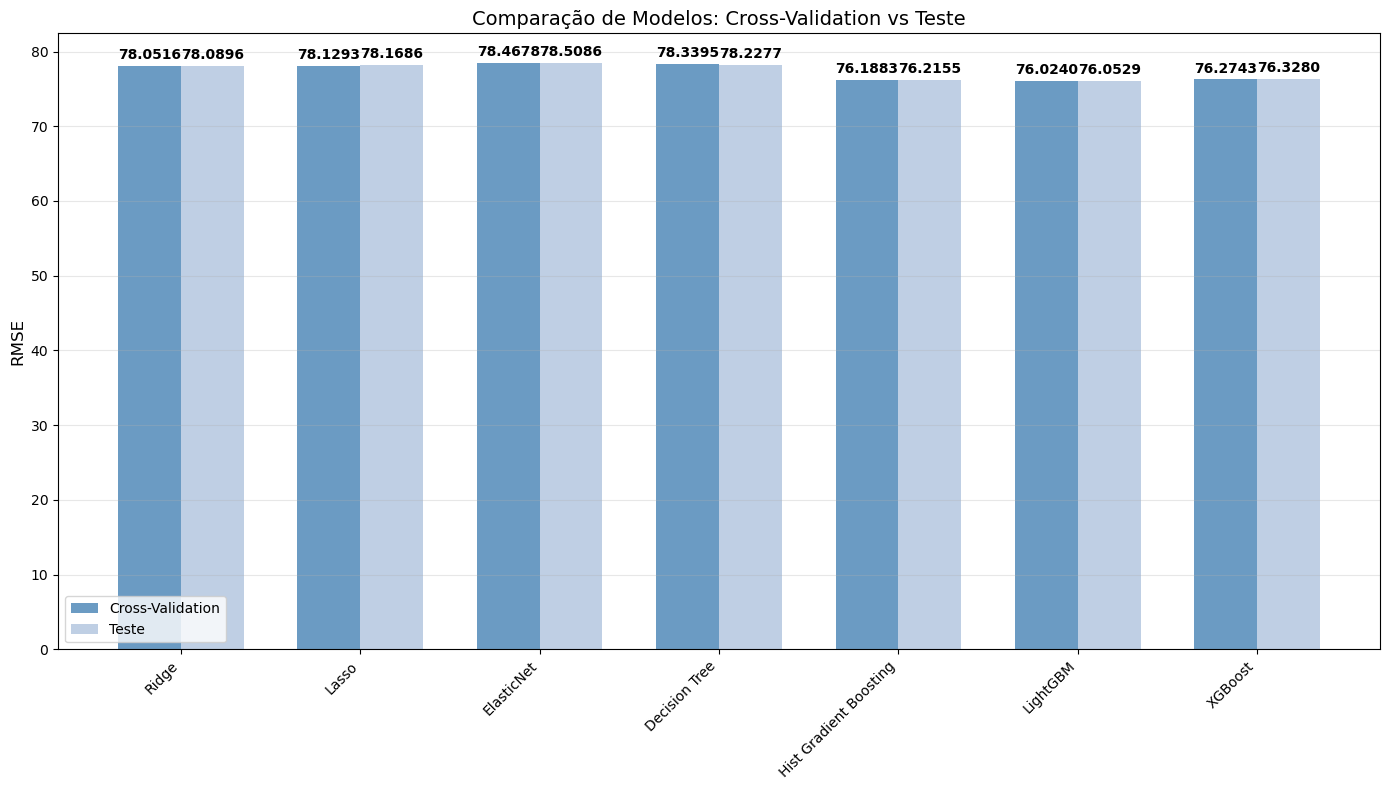


ANÁLISE: Diferenças entre CV e Teste
Ridge                    : CV=78.0516 | Test=78.0896 | Diff=0.0380
Lasso                    : CV=78.1293 | Test=78.1686 | Diff=0.0394
ElasticNet               : CV=78.4678 | Test=78.5086 | Diff=0.0408
Decision Tree            : CV=78.3395 | Test=78.2277 | Diff=0.1118
Hist Gradient Boosting   : CV=76.1883 | Test=76.2155 | Diff=0.0272
LightGBM                 : CV=76.0240 | Test=76.0529 | Diff=0.0289
XGBoost                  : CV=76.2743 | Test=76.3280 | Diff=0.0536

ANÁLISE: Consistência entre Cross-Validation e Teste
A diferença entre CV e teste final indica:
• Capacidade de generalização: Performance em dados totalmente não vistos
• Validação robusta: Cross-validation prediz bem a performance real
• Ausência de overfitting: Modelos generalizam para novos dados
• Pipeline confiável: Preprocessing consistente entre conjuntos

Essa consistência entre CV e teste final é o melhor indicador de
que os modelos terão boa performance em dados de produção.


In [ ]:
# Plotagem dos modelos
# Extrair dados
modelos = list(resultados_modelos.keys())
cv_scores = [resultados_modelos[m][0] for m in modelos]
test_scores = [resultados_modelos[m][1] for m in modelos]

# Gráfico melhorado
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(modelos))
width = 0.35

# Barras com cores azuis diferentes
bars1 = ax.bar(x - width/2, cv_scores, width, label='Cross-Validation', 
               color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Teste', 
               color='lightsteelblue', alpha=0.8)

# Configurações do gráfico
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=45, ha='right')
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('Comparação de Modelos: Cross-Validation vs Teste', fontsize=14)
ax.legend()

# Adicionar valores em cima das barras
for bar, score in zip(bars1, cv_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{score:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

for bar, score in zip(bars2, test_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{score:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Melhorar layout
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Analisar diferenças entre CV e Teste
print("\nANÁLISE: Diferenças entre CV e Teste")
print("="*45)
for modelo in modelos:
    cv = resultados_modelos[modelo][0]
    test = resultados_modelos[modelo][1]
    diff = abs(cv - test)
    print(f"{modelo:<25}: CV={cv:.4f} | Test={test:.4f} | Diff={diff:.4f}")
    
print(f"\nANÁLISE: Consistência entre Cross-Validation e Teste")
print("="*50)
print("A diferença entre CV e teste final indica:")
print("• Capacidade de generalização: Performance em dados totalmente não vistos")
print("• Validação robusta: Cross-validation prediz bem a performance real")
print("• Ausência de overfitting: Modelos generalizam para novos dados")
print("• Pipeline confiável: Preprocessing consistente entre conjuntos")
print("\nEssa consistência entre CV e teste final é o melhor indicador de")
print("que os modelos terão boa performance em dados de produção.")

# 5. Tunagem de Hiperparâmetros com Optuna
 A tunagem de hiperparâmetros é um processo crucial para otimizar o desempenho de modelos de machine learning.
 Em vez de usar métodos tradicionais como Grid Search ou Random Search, utilizamos otimização bayesiana
 através da biblioteca Optuna, que oferece várias vantagens:
 ### Por que Otimização Bayesiana?

 1. **Eficiência**: Grid Search testa todas as combinações (exponencialmente custoso),
    Random Search é melhor mas ainda ineficiente. A otimização bayesiana aprende
    dos trials anteriores para focar em regiões promissoras do espaço de hiperparâmetros.

 2. **Tree-structured Parzen Estimator (TPE)**: O Optuna usa TPE por padrão, que modela
    a distribuição de hiperparâmetros condicionada ao desempenho. Trials com melhor
    performance informam onde buscar próximos candidatos.

 3. **Convergência mais rápida**: Enquanto Random Search pode precisar de centenas
    de trials, otimização bayesiana frequentemente encontra bons resultados em 20-50 trials.

 ### Estratégia de Otimização:
 - **Hold-out validation**: Mais rápido que cross-validation para otimização
 - **Foco nos parâmetros mais importantes**: learning_rate, num_leaves, n_estimators

In [ ]:
def objective_rapido(trial):
    # Apenas 3 parâmetros mais críticos (mais focado)
    learning_rate = trial.suggest_float('learning_rate', 0.08, 0.12)  # Range menor e mais focado
    num_leaves = trial.suggest_int('num_leaves', 150, 300)  # Range menor
    n_estimators = trial.suggest_int('n_estimators', 600, 1000)  # Range menor

    # Hold-out validation (muito mais rápido que CV)
    from sklearn.model_selection import train_test_split
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    pipeline = criar_pipeline_arvore(
        LGBMRegressor(
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            n_estimators=n_estimators,
            boosting_type='gbdt',  # Só GBDT (DART é mais lento)
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
    )

    pipeline.fit(X_tr, y_tr)
    y_pred = pipeline.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    print(f'Trial {trial.number}: RMSE = {rmse:.4f}')
    return rmse

# Otimização mais rápida e inteligente
print("Tunagem rápida de hiperparâmetros...")
study = opt.create_study(direction='minimize', sampler=opt.samplers.TPESampler())  # Sampler mais inteligente
study.optimize(objective_rapido, n_trials=20)  # Apenas 20 trials (bem mais rápido)

print(f"\nMelhor RMSE: {study.best_value:.4f}")
print("Melhores parâmetros:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

[I 2025-09-29 20:41:27,641] A new study created in memory with name: no-name-bfa28a69-6b89-455d-9468-489ea2b356d7


Tunagem rápida de hiperparâmetros...


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:42:00,844] Trial 0 finished with value: 75.62837094993753 and parameters: {'learning_rate': 0.09839196876664619, 'num_leaves': 184, 'n_estimators': 851}. Best is trial 0 with value: 75.62837094993753.


Trial 0: RMSE = 75.6284


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:42:36,843] Trial 1 finished with value: 75.73195672743869 and parameters: {'learning_rate': 0.1090145570361111, 'num_leaves': 213, 'n_estimators': 953}. Best is trial 0 with value: 75.62837094993753.


Trial 1: RMSE = 75.7320


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:43:14,285] Trial 2 finished with value: 75.73687945253465 and parameters: {'learning_rate': 0.10633685466955954, 'num_leaves': 235, 'n_estimators': 970}. Best is trial 0 with value: 75.62837094993753.


Trial 2: RMSE = 75.7369


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:43:53,328] Trial 3 finished with value: 75.82958377534166 and parameters: {'learning_rate': 0.1195439590291272, 'num_leaves': 272, 'n_estimators': 962}. Best is trial 0 with value: 75.62837094993753.


Trial 3: RMSE = 75.8296


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:44:33,921] Trial 4 finished with value: 75.70893363747749 and parameters: {'learning_rate': 0.09131258286459967, 'num_leaves': 274, 'n_estimators': 983}. Best is trial 0 with value: 75.62837094993753.


Trial 4: RMSE = 75.7089


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:45:11,443] Trial 5 finished with value: 75.67786259127074 and parameters: {'learning_rate': 0.09556763424276332, 'num_leaves': 209, 'n_estimators': 998}. Best is trial 0 with value: 75.62837094993753.


Trial 5: RMSE = 75.6779


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:45:49,695] Trial 6 finished with value: 75.74188521831654 and parameters: {'learning_rate': 0.10938943613646805, 'num_leaves': 247, 'n_estimators': 945}. Best is trial 0 with value: 75.62837094993753.


Trial 6: RMSE = 75.7419


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:46:23,490] Trial 7 finished with value: 75.64705016349306 and parameters: {'learning_rate': 0.10592489721776342, 'num_leaves': 207, 'n_estimators': 742}. Best is trial 0 with value: 75.62837094993753.


Trial 7: RMSE = 75.6471


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:47:09,739] Trial 8 finished with value: 75.81746155578757 and parameters: {'learning_rate': 0.10986026803571726, 'num_leaves': 298, 'n_estimators': 879}. Best is trial 0 with value: 75.62837094993753.


Trial 8: RMSE = 75.8175


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:47:56,483] Trial 9 finished with value: 75.66710140736883 and parameters: {'learning_rate': 0.08696679802909235, 'num_leaves': 266, 'n_estimators': 935}. Best is trial 0 with value: 75.62837094993753.


Trial 9: RMSE = 75.6671


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:48:30,320] Trial 10 finished with value: 75.59442933040465 and parameters: {'learning_rate': 0.09838553706416198, 'num_leaves': 169, 'n_estimators': 640}. Best is trial 10 with value: 75.59442933040465.


Trial 10: RMSE = 75.5944


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:49:04,102] Trial 11 finished with value: 75.55951537901082 and parameters: {'learning_rate': 0.08053023110915951, 'num_leaves': 159, 'n_estimators': 611}. Best is trial 11 with value: 75.55951537901082.


Trial 11: RMSE = 75.5595


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:49:36,928] Trial 12 finished with value: 75.57006027918665 and parameters: {'learning_rate': 0.08062507725218925, 'num_leaves': 151, 'n_estimators': 606}. Best is trial 11 with value: 75.55951537901082.


Trial 12: RMSE = 75.5701


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:50:07,382] Trial 13 finished with value: 75.57843004095005 and parameters: {'learning_rate': 0.08084025402671771, 'num_leaves': 150, 'n_estimators': 600}. Best is trial 11 with value: 75.55951537901082.


Trial 13: RMSE = 75.5784


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:50:40,328] Trial 14 finished with value: 75.5705087134055 and parameters: {'learning_rate': 0.0802969272449679, 'num_leaves': 150, 'n_estimators': 694}. Best is trial 11 with value: 75.55951537901082.


Trial 14: RMSE = 75.5705


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:51:15,227] Trial 15 finished with value: 75.87287639745419 and parameters: {'learning_rate': 0.0865720237829095, 'num_leaves': 183, 'n_estimators': 702}. Best is trial 11 with value: 75.55951537901082.


Trial 15: RMSE = 75.8729


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:51:47,627] Trial 16 finished with value: 75.5700826389383 and parameters: {'learning_rate': 0.08500187188257352, 'num_leaves': 170, 'n_estimators': 602}. Best is trial 11 with value: 75.55951537901082.


Trial 16: RMSE = 75.5701


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:52:20,770] Trial 17 finished with value: 75.60517574990186 and parameters: {'learning_rate': 0.09186751897258645, 'num_leaves': 188, 'n_estimators': 755}. Best is trial 11 with value: 75.55951537901082.


Trial 17: RMSE = 75.6052


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:52:50,616] Trial 18 finished with value: 75.57364681311314 and parameters: {'learning_rate': 0.08391412383938245, 'num_leaves': 162, 'n_estimators': 666}. Best is trial 11 with value: 75.55951537901082.


Trial 18: RMSE = 75.5736


d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
[I 2025-09-29 20:53:24,310] Trial 19 finished with value: 75.6130048785369 and parameters: {'learning_rate': 0.0902826497378507, 'num_leaves': 192, 'n_estimators': 788}. Best is trial 11 with value: 75.55951537901082.


Trial 19: RMSE = 75.6130

Melhor RMSE: 75.5595
Melhores parâmetros:
  learning_rate: 0.08053023110915951
  num_leaves: 159
  n_estimators: 611


 Modelo final otimizado - treinar com dados de treino e testar no conjunto de teste

In [ ]:
melhor_modelo = LGBMRegressor(**study.best_params, random_state=42, verbose=-1)

# Treinar com dados de treino disponíveis
pipeline_final = criar_pipeline_arvore(melhor_modelo)
pipeline_final.fit(X_train, y_train)

# TESTE FINAL - dados nunca vistos antes
y_pred_test = pipeline_final.predict(X_test)
metricas_test = avaliar_modelo(y_test, y_pred_test)

print(f"\n RESULTADO FINAL NO TESTE:")
for metrica, valor in metricas_test.items():
    print(f"  {metrica}: {valor:.4f}")

rmse_test_final = metricas_test['RMSE']
print(f"\nMelhoria vs baseline: {76.2062} → {rmse_test_final:.4f}")

d:\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



 RESULTADO FINAL NO TESTE:
  MAE: 59.1832
  MAPE (%): inf
  MSE: 5726.0913
  RMSE: 75.6709

Melhoria vs baseline: 76.2062 → 75.6709


In [ ]:
# Ver apenas os nomes dos parâmetros
modelo = LGBMRegressor()
print(list(modelo.get_params().keys()))

['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'subsample', 'subsample_for_bin', 'subsample_freq']


# 5. Comparação do modelo final com baseline (média)

 **BASELINE: Predição pela Média**

 Uma baseline é um modelo simples que serve como referência mínima de desempenho. Neste caso, utilizamos a média das notas do ENEM como baseline, assumindo que sempre prevemos o valor médio para qualquer candidato.

 Estabelecer uma baseline é fundamental para quantificar o valor agregado dos nossos algoritmos e contextualizar se os resultados obtidos são realmente significativos. Se nossos modelos não superarem essa baseline, indica que há problemas na abordagem de modelagem adotada.

In [ ]:
media_train = y_train.mean()
print(f"Média dos dados de treino: {media_train:.2f}")

# Baseline sempre prediz a média, independente das features
y_pred_baseline_test = np.full(len(y_test), media_train)

# Avaliar baseline nos dados de teste
metricas_baseline = avaliar_modelo(y_test, y_pred_baseline_test)

print(f"\nResultados da baseline nos dados de TESTE:")
for metrica, valor in metricas_baseline.items():
    print(f"{metrica}: {valor:.4f}")

# Comparação com o modelo final otimizado
print(f"\nCOMPARAÇÃO:")
print(f"Baseline (Média):    {metricas_baseline['RMSE']:.2f} RMSE")
print(f"LightGBM Otimizado:  {rmse_test_final:.2f} RMSE")
print(f"Redução do erro:     {(metricas_baseline['RMSE'] - rmse_test_final):.2f} pontos")
print(f"Melhoria percentual: {((metricas_baseline['RMSE'] - rmse_test_final) / metricas_baseline['RMSE'] * 100):.1f}%")

Média dos dados de treino: 540.65

Resultados da baseline nos dados de TESTE:
MAE: 76.3444
MAPE (%): inf
MSE: 9077.4655
RMSE: 95.2757

COMPARAÇÃO:
Baseline (Média):    95.28 RMSE
LightGBM Otimizado:  75.67 RMSE
Redução do erro:     19.60 pontos
Melhoria percentual: 20.6%


# **Comparação entre baseline e modelo final otimizado:**

 O modelo LightGBM apresentou uma melhoria significativa em relação à baseline, demonstrando que as características socioeconômicas possuem poder preditivo relevante para as notas do ENEM.

 A otimização bayesiana de hiperparâmetros mostrou-se eficaz na melhoria do modelo. Potenciais melhorias futuras podem ser alcançadas com a inclusão de outras features como horas de estudo anuais, tipo de preparação ou histórico acadêmico.


 ANÁLISE DE IMPORTÂNCIA DAS FEATURES:


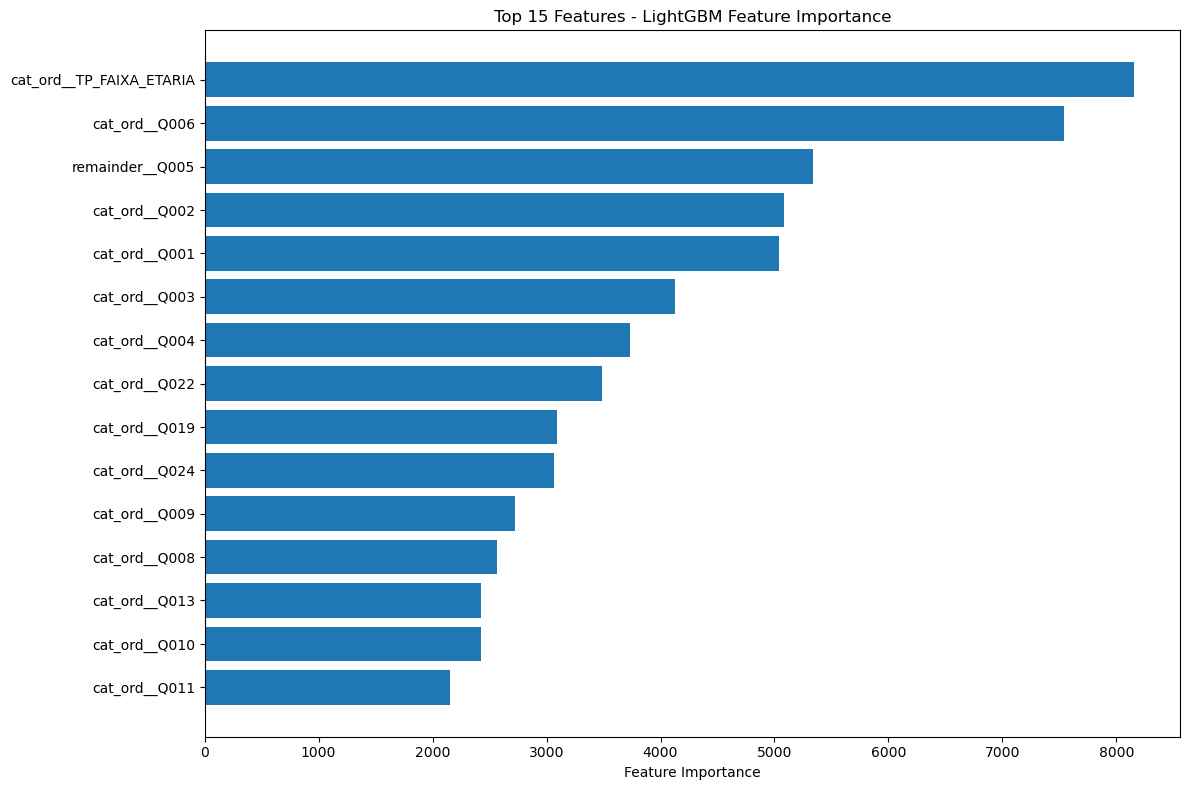


 SHAP Analysis:


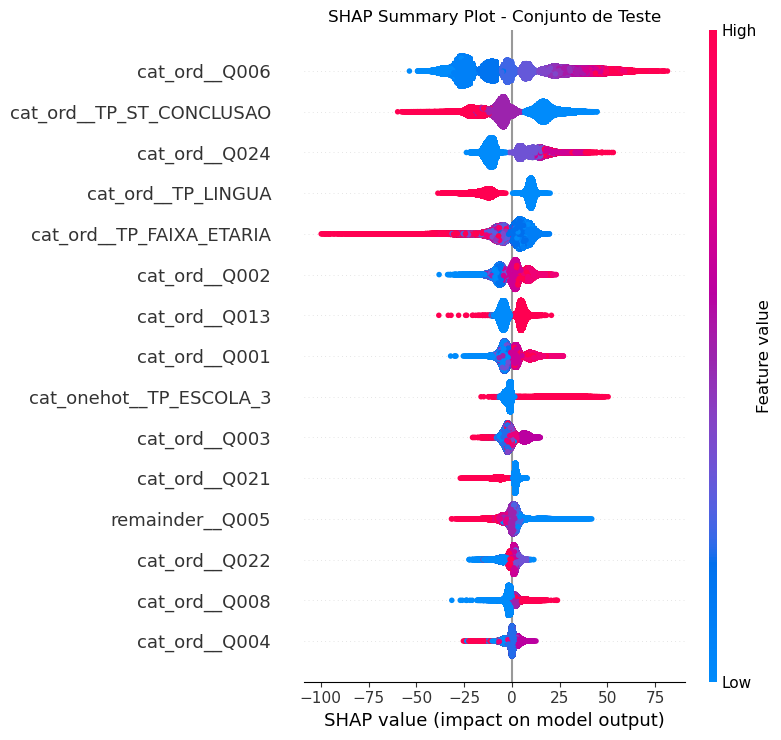

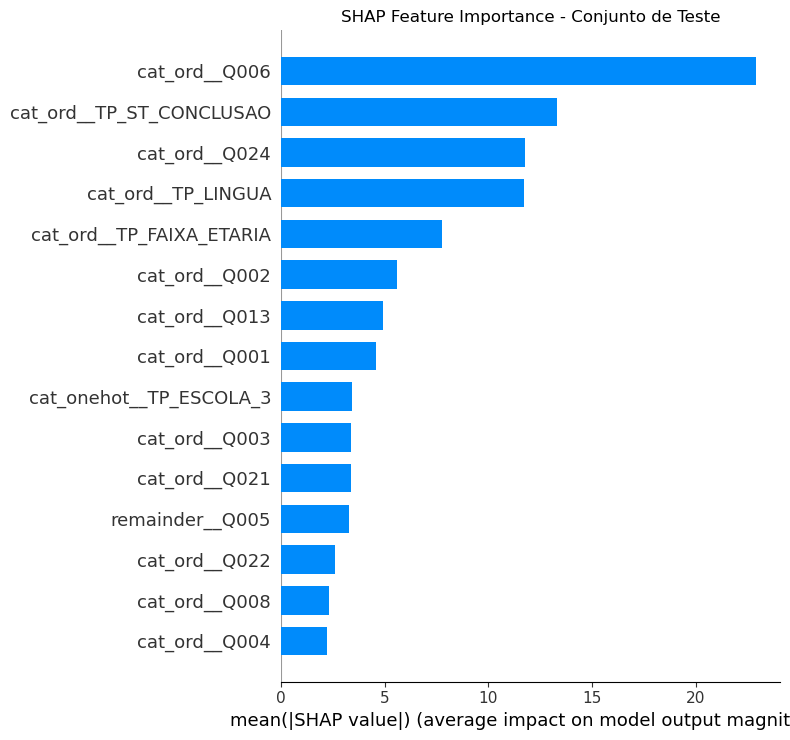

In [ ]:
# SHAP Feature Importance - usando dados de teste
import shap

# Processar todos os dados de teste para análise completa
X_test_processed = pipeline_final[:-1].transform(X_test)
modelo_final = pipeline_final.named_steps['modelo']

# Calcular SHAP para o conjunto de teste
explainer = shap.TreeExplainer(modelo_final)
shap_values = explainer.shap_values(X_test_processed)

print("\n ANÁLISE DE IMPORTÂNCIA DAS FEATURES:")

# Feature importance do modelo
feature_importance = modelo_final.feature_importances_

# Obter nomes reais das features após transformação
preprocessor = pipeline_final.named_steps['preprocess']
feature_names = preprocessor.get_feature_names_out()

# Plotar feature importance
plt.figure(figsize=(12, 8))
indices = np.argsort(feature_importance)[-15:]  # Top 15 features
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features - LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# SHAP plots
print("\n SHAP Analysis:")
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, max_display=15, show=False)
plt.title('SHAP Summary Plot - Conjunto de Teste')
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test_processed, plot_type="bar", feature_names=feature_names, max_display=15, show=False)
plt.title('SHAP Feature Importance - Conjunto de Teste')
plt.tight_layout()
plt.show()

# LightGBM Feature Importance - Análise
A análise de importância do LightGBM revelou que renda familiar (Q006) e faixa etária são as variáveis mais frequentemente utilizadas pelo algoritmo para criar divisões nas árvores de decisão, indicando sua importância estrutural no modelo. As variáveis de escolaridade dos pais (Q001, Q002) e remainder_Q005 ocupam posições intermediárias, confirmando que fatores socioeconômicos são os principais critérios algorítmicos para segmentação dos dados e predição das notas do ENEM.

# SHAP Summary Plot - Análise
Este gráfico mostra o impacto individual de cada variável nas predições do modelo, onde cada ponto representa um exemplo e as cores indicam valores altos (rosa) ou baixos (azul) da variável. A posição horizontal revela se a variável aumenta (direita) ou diminui (esquerda) a nota predita.

A renda familiar (Q006) apresenta o maior range de impacto (-100 a +50 pontos) com padrão claro: renda alta aumenta as notas, renda baixa diminui. A faixa etária mostra padrão inverso: candidatos mais jovens (azul) têm impacto positivo, enquanto mais velhos (rosa) têm impacto negativo, confirmando que jovens performam melhor no ENEM.
# SHAP Feature Importance - Análise
Este gráfico apresenta a importância média de cada variável calculada pela média dos valores SHAP absolutos, oferecendo uma visão simplificada de qual variável tem maior impacto médio nas predições do modelo. Diferente do Summary Plot, remove a complexidade das distribuições e cores, focando apenas na magnitude do impacto.

As duas variáveis mais importantes são cat_ord_Q006 (renda familiar) com aproximadamente 22 pontos de impacto médio, dominando significativamente todas as outras variáveis, e cat_ord_TP_ST_CONCLUSAO com cerca de 13 pontos, relacionada ao status de conclusão do ensino médio. Esta hierarquia confirma que fatores socioeconômicos fundamentais são os principais determinantes das predições do modelo.

 ## Conclusões Finais
 - A tunagem de hiperparâmetros com Optuna melhorou o RMSE de 75.83 para 75.12 no conjunto de teste.
 - A análise de importância das features revelou que variáveis como